In [91]:
%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton, MouseEvent
import geoengine as ge
from geoengine.workflow_builder.operators import TemporalRasterAggregation, RasterStacker, RenameBands, \
    RasterTypeConversion, Expression, GdalSource, RasterVectorJoin, OgrSource
import numpy as np
from typing import Tuple, Callable, Optional
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from skl2onnx import to_onnx # TODO: in ge library
from geoengine_openapi_client.models import MlModelMetadata, RasterDataType # TODO: better import

In [2]:
def points_by_drawing(filename: str,
                      color: str,
                      crs: str,
                      background: Callable[[plt.Axes], None],
                      figsize: Optional[Tuple[int, int]] = None) -> None:

    try:
        points = gpd.read_file(filename)
        points.set_crs(crs, inplace=True, allow_override=True)
    except:
        points = gpd.GeoDataFrame(crs=crs, geometry=[])

    fig, ax = plt.subplots(figsize=figsize)

    background(ax)

    def on_click(event: MouseEvent):
        if event.button is not MouseButton.LEFT:
            return
        if not event.inaxes:
            return
        
        points.loc[len(points)] = [Point(event.xdata, event.ydata)]

        points.plot(ax=ax, c=color)

        points.to_file(filename)

    fig.canvas.mpl_connect('button_press_event', on_click)

    points.plot(ax=ax, c=color)


In [3]:
koeln_center_utm = [356766, 5644819]

In [4]:
ge.initialize("http://localhost:3030/api")

In [93]:
def _query_rectangle(*,
                     center: Tuple[float, float],
                     time: np.datetime64,
                     radius_px: float = 512) -> ge.QueryRectangle:
    resolution = ge.SpatialResolution(10, 10)
    bbox = ge.BoundingBox2D(
        xmin=center[0] - resolution.x_resolution * radius_px,
        xmax=center[0] + resolution.x_resolution * radius_px,
        ymin=center[1] - resolution.y_resolution * radius_px,
        ymax=center[1] + resolution.y_resolution * radius_px,
    )
    return ge.QueryRectangle(
        spatial_bounds=bbox,
        time_interval=ge.TimeInterval(time),
        srs='EPSG:32632',
        resolution=resolution,
    )

red_band = GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B04`")
green_band = GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B03`")
blue_band = GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B02`")
nir_band = GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B08`")
mask_band = RasterTypeConversion(
    GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:SCL`"),
    output_data_type='U16',
)

workflow = TemporalRasterAggregation(
    aggregation_type='mean',
    granularity='months',
    window_size=1,
    ignore_no_data=True,
    source=RasterStacker(
        sources=[
            Expression(
                expression="if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }",
                output_type="F32",
                source=RasterStacker([red_band, mask_band]),
            ),
            Expression(
                expression="if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }",
                output_type="F32",
                source=RasterStacker([green_band, mask_band]),
            ),
            Expression(
                expression="if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }",
                output_type="F32",
                source=RasterStacker([blue_band, mask_band]),
            ),
            Expression(
                expression="if (C == 3 || (C >= 7 && C <= 11)) { NODATA } else { (A - B) / (A + B) }",
                output_type="F32",
                source=RasterStacker([nir_band, red_band, mask_band]),
            ),
            # RasterTypeConversion(
            #     ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B04"),
            #     output_data_type="F32",
            # ),
            # RasterTypeConversion(
            #     ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B03"),
            #     output_data_type="F32",
            # ),
            # RasterTypeConversion(
            #     ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B02"),
            #     output_data_type="F32",
            # ),
            # ge.workflow_builder.blueprints.sentinel2_cloud_free_ndvi(),
        ],
        rename=RenameBands.rename(['red', 'green', 'blue', 'ndvi']),
    )
)

workflow = ge.register_workflow(workflow)

query_rectangle = _query_rectangle(
    center=koeln_center_utm,
    time=np.datetime64("2022-07-01T00:00:00"),
    radius_px=512,
)

data_array = await workflow.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0,1,2,3], # TODO: improve for user, default = all? where are the band names?
)


/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


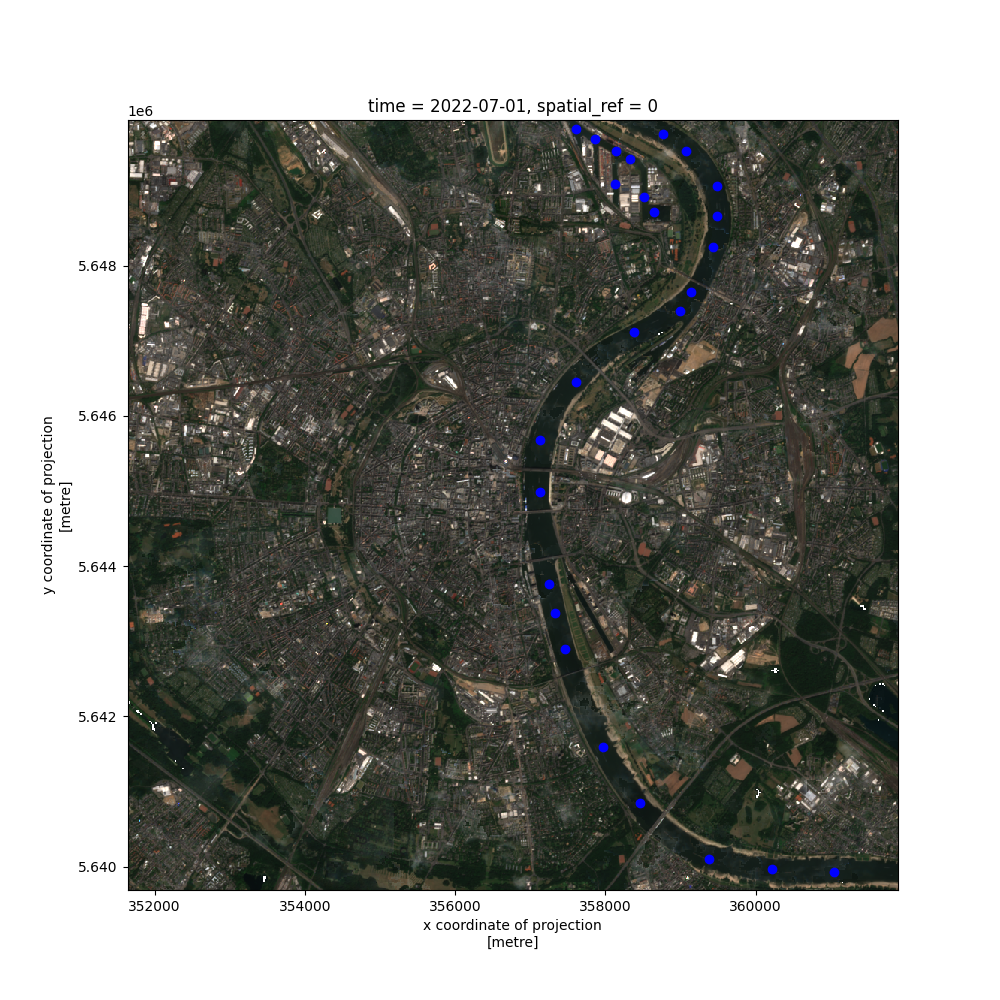

In [96]:
points_by_drawing(
    "water.geojson",
    color="blue",
    crs=str(data_array.rio.crs),
    background=lambda ax: data_array.isel(time=0, band=[0,1,2]).plot.imshow(
        rgb="band",
        vmax=4000,
        ax=ax,
    ),
    figsize=(10,10),
)

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


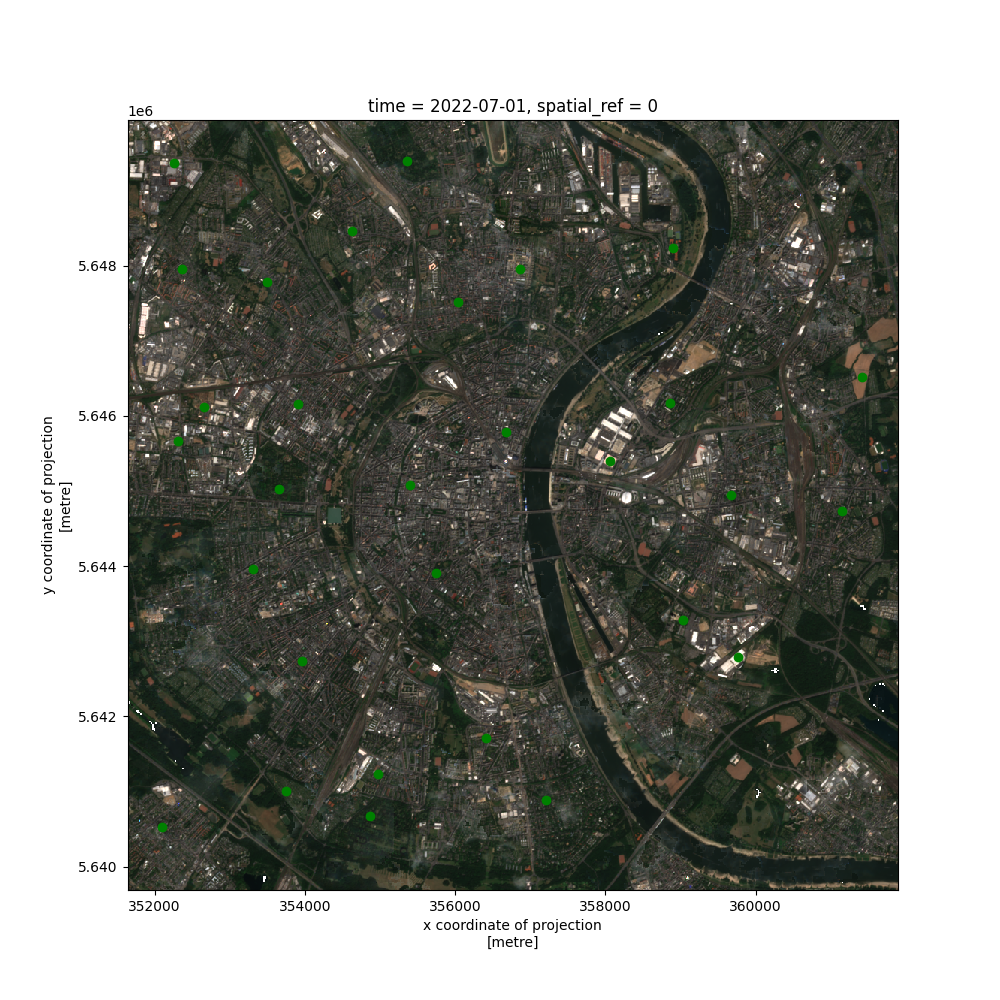

In [7]:
points_by_drawing(
    "non_water.geojson",
    color="green",
    crs=str(data_array.rio.crs),
    background=lambda ax: data_array.isel(time=0, band=[0,1,2]).plot.imshow(
        rgb="band",
        vmax=4000,
        ax=ax,
    ),
    figsize=(10,10),
)

In [97]:
labels = pd.concat(
    [
        gpd.read_file("water.geojson").assign(water=1),
        gpd.read_file("non_water.geojson").assign(water=0),
    ],
    ignore_index=True,
).set_crs(
    str(data_array.rio.crs),
    allow_override=True,
# ).assign(
#     start="2022-07-01",
#     end="2022-08-01"
)

labels_name = ge.upload_dataframe(
    labels,
    # time=ge.datasets.OgrSourceDatasetTimeType.start_end(
    #     start_field="start",
    #     start_format=ge.datasets.OgrSourceTimeFormat.auto(),
    #     end_field="end",
    #     end_format=ge.datasets.OgrSourceTimeFormat.auto(),
    # )
)

labels_name

ddeeddd5-a45d-40cc-b692-a005f93643df:82b7a3b3-8b88-45a7-b21b-295549e7ff9f

In [98]:
training_workflow = RasterVectorJoin(
    raster_sources=[workflow.workflow_definition().operator],
    vector_source=OgrSource(labels_name),
    names=ge.workflow_builder.operators.ColumnNames.default(),
    temporal_aggregation="none",
    feature_aggregation="first",
    temporal_aggregation_ignore_nodata=True,
    feature_aggregation_ignore_nodata=True,
)

training_workflow = ge.register_workflow(training_workflow)

training_df = training_workflow.get_dataframe(query_rectangle)

training_df.head()

geometry        blue       green      ndvi  \
0  POINT (359492.047 5649059.959)  458.799988  485.799988 -0.158283   
1  POINT (359436.582 5648255.711)  395.500000  439.250000 -0.203166   
2  POINT (361045.078 5639935.905)  502.500000  561.666687 -0.239277   
3  POINT (359381.116 5640102.302)  416.000000  478.399994 -0.160315   
4  POINT (357966.750 5641599.867)  412.500000  486.000000 -0.079246   

          red  water                     start                       end  
0  328.399994      1 2022-07-01 00:00:00+00:00 2022-08-01 00:00:00+00:00  
1  279.000000      1 2022-07-01 00:00:00+00:00 2022-08-01 00:00:00+00:00  
2  407.500000      1 2022-07-01 00:00:00+00:00 2022-08-01 00:00:00+00:00  
3  337.200012      1 2022-07-01 00:00:00+00:00 2022-08-01 00:00:00+00:00  
4  332.666656      1 2022-07-01 00:00:00+00:00 2022-08-01 00:00:00+00:00

In [61]:
training_workflow = RasterVectorJoin(
    raster_sources=[RasterStacker(
        sources=[
            RasterTypeConversion(
                ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B04"),
                output_data_type="F32",
            ),
            RasterTypeConversion(
                ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B03"),
                output_data_type="F32",
            ),
            RasterTypeConversion(
                ge.workflow_builder.blueprints.sentinel2_cloud_free_band("B02"),
                output_data_type="F32",
            ),
            ge.workflow_builder.blueprints.sentinel2_cloud_free_ndvi(),
        ],
        rename=RenameBands.rename(['red', 'green', 'blue', 'ndvi']),
    )],
    vector_source=OgrSource(labels_name),
    names=ge.workflow_builder.operators.ColumnNames.default(),
    temporal_aggregation="mean",
    feature_aggregation="first",
    temporal_aggregation_ignore_nodata=True,
    feature_aggregation_ignore_nodata=True,
)

training_workflow = ge.register_workflow(training_workflow)

query_rectangle2 = ge.QueryRectangle(
    spatial_bounds=query_rectangle.spatial_bounds,
    time_interval=ge.TimeInterval(np.datetime64("2022-07-01T00:00:00"), np.datetime64("2022-08-01T00:00:00")),
    srs='EPSG:32632',
    resolution=query_rectangle.spatial_resolution,
)
training_df = training_workflow.get_dataframe(query_rectangle2)

training_df.head()

geometry  blue                       end  green  \
0  POINT (359492.047 5649059.959)   0.0 2022-08-01 00:00:00+00:00    0.0   
1  POINT (359436.582 5648255.711)   0.0 2022-08-01 00:00:00+00:00    0.0   
2  POINT (361045.078 5639935.905)   0.0 2022-08-01 00:00:00+00:00    0.0   
3  POINT (359381.116 5640102.302)   0.0 2022-08-01 00:00:00+00:00    0.0   
4  POINT (357966.750 5641599.867)   0.0 2022-08-01 00:00:00+00:00    0.0   

   ndvi         red                     start  water  
0   0.0  117.285714 2022-07-01 00:00:00+00:00      1  
1   0.0   79.714286 2022-07-01 00:00:00+00:00      1  
2   0.0  174.642857 2022-07-01 00:00:00+00:00      1  
3   0.0  120.428571 2022-07-01 00:00:00+00:00      1  
4   0.0  142.571429 2022-07-01 00:00:00+00:00      1

In [54]:
await training_workflow.vector_stream_into_geopandas(query_rectangle)

water          red  green  blue      ndvi  \
0       1   328.399994    0.0   0.0  0.000000   
1       1   279.000000    0.0   0.0  0.000000   
2       1   407.500000    0.0   0.0 -0.239277   
3       1   337.200012    0.0   0.0 -0.160315   
4       1   332.666656    0.0   0.0  0.000000   
5       1   357.500000    0.0   0.0  0.000000   
6       1   303.600006    0.0   0.0  0.000000   
7       1   397.000000    0.0   0.0  0.000000   
8       1   376.000000    0.0   0.0  0.000000   
9       1   318.666656    0.0   0.0  0.000000   
10      1   292.500000    0.0   0.0  0.000000   
11      1   287.666656    0.0   0.0  0.000000   
12      1   292.200012    0.0   0.0  0.000000   
13      1   344.750000    0.0   0.0  0.000000   
14      1   689.200012    0.0   0.0  0.000000   
15      1   312.833344    0.0   0.0 -0.169128   
16      1   428.333344    0.0   0.0 -0.094667   
17      1   318.500000    0.0   0.0  0.000000   
18      1   398.000000    0.0   0.0  0.000000   
19      1   361.000000    0.0   0.0  0.000000   
20      1   428.000000    0.0   0.0  0.000000   
21      1   560.000000    0.0   0.0  0.000000   
22      1   405.200012    0.0   0.0  0.000000   
23      1   338.000000    0.0   0.0  0.000000   
24      1   286.600006    0.0   0.0  0.000000   
25      1   284.399994    0.0   0.0  0.000000   
26      0  1315.000000    0.0   0.0  0.000000   
27      0  1202.500000    0.0   0.0  0.000000   
28      0  1035.142822    0.0   0.0  0.000000   
29      0  1400.500000    0.0   0.0  0.000000   
30      0   354.200012    0.0   0.0  0.000000   
31      0   423.500000    0.0   0.0  0.000000   
32      0  1906.800049    0.0   0.0  0.000000   
33      0  3848.800049    0.0   0.0  0.000000   
34      0  4677.714355    0.0   0.0  0.000000   
35      0  1165.666626    0.0   0.0  0.000000   
36      0  1325.333374    0.0   0.0  0.000000   
37      0   812.833313    0.0   0.0  0.000000   
38      0  1058.333374    0.0   0.0  0.000000   
39      0   506.666656    0.0   0.0  0.000000   
40      0   992.333313    0.0   0.0  0.000000   
41      0  1324.800049    0.0   0.0  0.000000   
42      0  1300.000000    0.0   0.0  0.000000   
43      0  1041.599976    0.0   0.0  0.000000   
44      0   556.000000    0.0   0.0  0.000000   
45      0   683.799988    0.0   0.0  0.000000   
46      0   824.000000    0.0   0.0  0.000000   
47      0   571.400024    0.0   0.0  0.000000   
48      0   664.666687    0.0   0.0  0.000000   
49      0   945.200012    0.0   0.0  0.000000   
50      0  1024.199951    0.0   0.0  0.000000   
51      0   526.799988    0.0   0.0  0.000000   
52      0   919.500000    0.0   0.0  0.000000   
53      0   867.571411    0.0   0.0  0.000000   
54      0  1321.199951    0.0   0.0  0.000000   
55      0  2564.399902    0.0   0.0  0.000000   

                               geometry                time_start  \
0   MULTIPOINT (359492.047 5649059.959) 2022-07-01 00:00:00+00:00   
1   MULTIPOINT (359436.582 5648255.711) 2022-07-01 00:00:00+00:00   
2   MULTIPOINT (361045.078 5639935.905) 2022-07-01 00:00:00+00:00   
3   MULTIPOINT (359381.116 5640102.302) 2022-07-01 00:00:00+00:00   
4   MULTIPOINT (357966.750 5641599.867) 2022-07-01 00:00:00+00:00   
5   MULTIPOINT (357328.898 5643374.758) 2022-07-01 00:00:00+00:00   
6   MULTIPOINT (357134.769 5644983.254) 2022-07-01 00:00:00+00:00   
7   MULTIPOINT (357134.769 5645676.571) 2022-07-01 00:00:00+00:00   
8   MULTIPOINT (357606.225 5646453.086) 2022-07-01 00:00:00+00:00   
9   MULTIPOINT (358382.740 5647118.671) 2022-07-01 00:00:00+00:00   
10  MULTIPOINT (358992.859 5647395.997) 2022-07-01 00:00:00+00:00   
11  MULTIPOINT (357467.561 5642903.303) 2022-07-01 00:00:00+00:00   
12  MULTIPOINT (357245.700 5643763.016) 2022-07-01 00:00:00+00:00   
13  MULTIPOINT (359076.057 5649531.414) 2022-07-01 00:00:00+00:00   
14  MULTIPOINT (358770.997 5649753.276) 2022-07-01 00:00:00+00:00   
15  MULTIPOINT (360213.097 5639963.638) 2022-07-01 00:00:00+00:00   
16  MULTIPOINT (358465.938 5640851.08

In [99]:
training_workflow.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:32632
Columns:
  red:
    Column Type: float
    Measurement: unitless
  green:
    Column Type: float
    Measurement: unitless
  ndvi:
    Column Type: float
    Measurement: unitless
  blue:
    Column Type: float
    Measurement: unitless
  water:
    Column Type: int
    Measurement: unitless

<Axes: title={'center': 'time = 2022-07-01, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


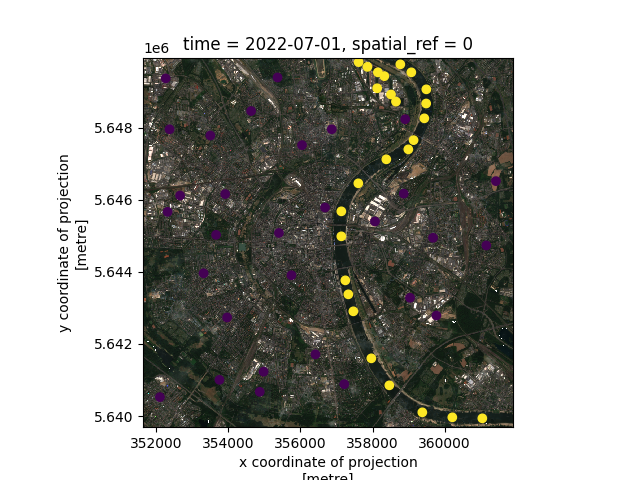

In [95]:
fig, ax = plt.subplots()

data_array.isel(time=0, band=[0,1,2]).plot.imshow(
    rgb="band",
    vmax=4000,
    ax=ax,
)

ge.register_workflow(OgrSource(labels_name)).get_dataframe(query_rectangle).plot(ax=ax, column="water", k=2)

In [89]:
data_array.sel(x=359492.047, y=5649059.959, method="nearest")

<xarray.DataArray (time: 1, band: 4)>
array([[328.4,   nan,   nan,   nan]], dtype=float32)
Coordinates:
    x            float64 3.595e+05
    y            float64 5.649e+06
  * time         (time) datetime64[ns] 2022-07-01
  * band         (band) int64 0 1 2 3
    spatial_ref  int64 0

In [71]:
ge.register_workflow(OgrSource(labels_name)).get_dataframe(query_rectangle).head()

geometry                       end  \
0  POINT (359492.047 5649059.959) 2022-08-01 00:00:00+00:00   
1  POINT (359436.582 5648255.711) 2022-08-01 00:00:00+00:00   
2  POINT (361045.078 5639935.905) 2022-08-01 00:00:00+00:00   
3  POINT (359381.116 5640102.302) 2022-08-01 00:00:00+00:00   
4  POINT (357966.750 5641599.867) 2022-08-01 00:00:00+00:00   

                      start  water  
0 2022-07-01 00:00:00+00:00      1  
1 2022-07-01 00:00:00+00:00      1  
2 2022-07-01 00:00:00+00:00      1  
3 2022-07-01 00:00:00+00:00      1  
4 2022-07-01 00:00:00+00:00      1

In [85]:
data_array.isel(band=[0,1,2], time=0).plot.imshow(
        rgb="band",
        vmax=4000,
    )

In [83]:
data_array.isel(band=[1,2,3], time=0)

<xarray.DataArray (band: 3, y: 1025, x: 1025)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.31510416,
         0.2800835 , 0.25557625],
        [       nan,        nan,        nan, ..., 0.46041304,
         0.38645965, 0.36896938],
        [       nan,        nan,        nan, ..., 0.5778574 ,
         0.47240338, 0.5004605 ]]], dtype=float32)
Coordinates:
  * x            (x) float64 3.516e+05 3.517e+05 ... 3.619e+05 3.619e+05
  * y            (y) float64 5.65e+06 5.65e+06 5.65e+06 ... 5.64e+06 5.64e+06
    time         datetime64[ns] 2022-07-01
  * band         (band) int64 1 2 3
    spatial_ref  int64 0

In [121]:
X = training_df[["red", "green", "blue", "ndvi"]].to_numpy()
print(X[:5])

[[ 3.28399994e+02  4.85799988e+02  4.58799988e+02 -1.58283174e-01]
 [ 2.79000000e+02  4.39250000e+02  3.95500000e+02 -2.03166321e-01]
 [ 4.07500000e+02  5.61666687e+02  5.02500000e+02 -2.39277333e-01]
 [ 3.37200012e+02  4.78399994e+02  4.16000000e+02 -1.60314709e-01]
 [ 3.32666656e+02  4.86000000e+02  4.12500000e+02 -7.92462304e-02]]


In [123]:
y = training_df["water"].to_numpy()
print(y[:5])

[1 1 1 1 1]


In [124]:
clf = RandomForestClassifier(random_state=42)

clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [125]:
onx = to_onnx(clf, X[:1], target_opset=9) # target_opset is the ONNX version to use

In [114]:
X[:1].to_numpy()

array([[ 3.28399994e+02,  4.85799988e+02,  4.58799988e+02,
        -1.58283174e-01]])